### Exploratory Data Analysis
- Select the top, middle and worst performare ETFs and Stocks
- Determine their exact performance from 2000 1st of Jan
- - The best, worst and still holding performance
-  try to understand their volatility profile
-  understand the correlation between
- - ETFs
- - Stocks
- - ETFs and Stock
- Select the symbols and performance measures for baseline comparison

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import os
import pickle
import itertools

In [2]:
# change into Dataset't directory
os.chdir("../dataset")

In [3]:
# Load previously saved pickles

# load objects
with open("2_2_symbols_info.pckl", "rb") as f:
    %time symbols_info = pickle.load(f)

CPU times: user 691 µs, sys: 1.1 ms, total: 1.79 ms
Wall time: 1.72 ms


In [4]:
with open("2_2_etfs.pckl", "rb") as f:
    %time ETFs = pickle.load(f)

CPU times: user 612 ms, sys: 297 ms, total: 909 ms
Wall time: 915 ms


In [5]:
with open("2_2_stocks.pckl", "rb") as f:
    %time Stocks = pickle.load(f)

CPU times: user 2.21 s, sys: 1.28 s, total: 3.49 s
Wall time: 3.61 s


In [6]:
# Filter the symbols_info to get ETFs and Stocks that have engough data that it will be meaningful for training models
ETFs_pre2000 = symbols_info.loc[(symbols_info["First Seen"] <= "2000-01-01") & (symbols_info["ETF"] == True)]
Stocks_pre2000 = symbols_info.loc[(symbols_info["First Seen"] <= "2000-01-01") & (symbols_info["ETF"] == False)]

In [7]:
# Drop non interesting ETFs
ETFs_pre2000_keys = ETFs_pre2000["Symbol"].values.tolist()
ETFs = {key: ETFs[key] for key in ETFs_pre2000_keys}
print("There is {} interesting ETF".format(len(ETFs)))

There is 32 interesting ETF


In [8]:
# Drop non interesting Stocks
Stocks_pre2000_keys = Stocks_pre2000["Symbol"].values.tolist()
Stocks = {key: Stocks[key] for key in Stocks_pre2000_keys}
print("There is {} interesting Stock".format(len(Stocks)))

There is 1856 interesting Stock


In [9]:
# Removing some interesting outliers
# ELA (Envela Corporation) for example have very small negative prices for a very long time.

ELA = Stocks["ELA"]

In [10]:
ELA["Adj Close"].describe()

count    7924.000000
mean        0.688563
std         1.664723
min        -0.000910
25%        -0.000006
50%        -0.000003
75%         0.000034
max         8.370000
Name: Adj Close, dtype: float64

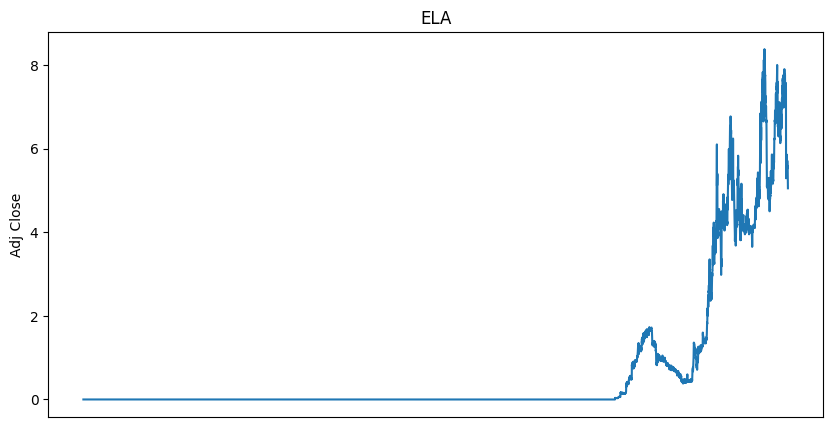

In [11]:
# Plot ELA's data and try to understand it better what is going on with the Adj Close price

plt.figure(figsize=(10, 5))
plt.title("ELA")
plt.plot(ELA["Date"], ELA["Adj Close"])
plt.ylabel("Adj Close")
plt.xticks([])
plt.show()

In [12]:
# Symbols with value equal or smaller than yero should be removed
zero_or_less = []
for key, df in {**ETFs, **Stocks}.items():
    if df[df["Adj Close"] <= 0]["Adj Close"].any():
        zero_or_less.append(key)

print(zero_or_less)

['SID', 'VHI', 'SEE', 'ELA', 'NVO', 'AIV', 'ERIC']


In [13]:
ETFs = {key: ETFs[key] for key in ETFs.keys() if key not in zero_or_less}
print("There is {} interesting ETF remains".format(len(ETFs)))

There is 32 interesting ETF remains


In [14]:
Stocks = {key: Stocks[key] for key in Stocks.keys() if key not in zero_or_less}
print("There is {} interesting Stock remains".format(len(Stocks)))

There is 1849 interesting Stock remains


In [15]:
# Drop all datarows that older than 2000 1st of Jan from all symbols data
for key, df in {**ETFs, **Stocks}.items():
    df.drop(df[df["Date"] < "2000-01-01"].index, inplace=True)
    if key in ETFs :
        ETFs[key] = df
    else:
        Stocks[key] = df

In [16]:
# Get ETFs and Stocks best, worst and still holding return if it was bought on 2000 1st of Jan
# These are possible returns
# To get the best performance get the max price with date for a possible exit
# To get the worst performance get the min price with data for a possible exit
# The holding price is the last price in the datarow

tmp_list = []
for key, df in {**ETFs, **Stocks}.items():
    etf = True if key in ETFs else False
    tmp_list.append([key,
                     df["Date"].iloc[0],
                     df["Adj Close"].iloc[0],
                     df[1:]["Adj Close"].idxmax(),
                     df[1:]["Adj Close"].max(),
                     df[1:]["Adj Close"].idxmin(),
                     df[1:]["Adj Close"].min(),
                     df["Date"].iloc[-1],
                     df["Adj Close"].iloc[-1],
                     etf])
baseline_performance = pd.DataFrame(tmp_list, columns=["Symbol", 
                                    "First Date", "First Adj Close",
                                    "Highest Adj Close Date", "Highest Adj Close",
                                    "Lowest Adj Close Date", "Lowest Adj Close", 
                                    "Current Adj Close Date", "Current Adj Close", 
                                     "ETF"])

In [17]:
baseline_performance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1881 entries, 0 to 1880
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Symbol                  1881 non-null   object        
 1   First Date              1881 non-null   object        
 2   First Adj Close         1881 non-null   float64       
 3   Highest Adj Close Date  1881 non-null   datetime64[ns]
 4   Highest Adj Close       1881 non-null   float64       
 5   Lowest Adj Close Date   1881 non-null   datetime64[ns]
 6   Lowest Adj Close        1881 non-null   float64       
 7   Current Adj Close Date  1881 non-null   object        
 8   Current Adj Close       1881 non-null   float64       
 9   ETF                     1881 non-null   bool          
dtypes: bool(1), datetime64[ns](2), float64(4), object(3)
memory usage: 134.2+ KB


In [18]:
baseline_performance.head()

,Symbol,First Date,First Adj Close,Highest Adj Close Date,Highest Adj Close,Lowest Adj Close Date,Lowest Adj Close,Current Adj Close Date,Current Adj Close,ETF
0,EWJ,2000-01-03,47.173790,2021-09-15,74.120003,2003-04-25,19.765661,2023-09-01,62.040001,True
1,EWM,2000-01-03,11.309934,2014-08-27,36.642010,2001-04-09,5.949835,2023-09-01,21.230000,True
2,EWC,2000-01-03,8.789878,2022-03-30,40.660000,2002-10-09,5.766855,2023-09-01,34.930000,True
3,EWD,2000-01-03,13.207083,2021-08-13,48.970001,2002-10-09,4.161988,2023-09-01,33.150002,True
4,EWQ,2000-01-03,15.425147,2021-11-08,40.450001,2003-03-12,7.749478,2023-09-01,37.430000,True


In [19]:
baseline_performance.tail()

,Symbol,First Date,First Adj Close,Highest Adj Close Date,Highest Adj Close,Lowest Adj Close Date,Lowest Adj Close,Current Adj Close Date,Current Adj Close,ETF
1876,SMG,2000-01-03,10.854502,2021-04-05,248.619339,2000-10-17,8.194081,2023-09-01,55.029999,False
1877,HL,2000-01-03,1.477444,2008-04-16,12.320698,2000-11-01,0.472782,2023-09-01,4.350000,False
1878,MTCH,2000-01-03,6.643321,2021-10-21,175.529999,2009-03-09,3.392253,2023-09-01,46.459999,False
1879,TPC,2000-01-03,3.889185,2007-07-23,70.737694,2000-05-30,2.692513,2023-09-01,8.850000,False
1880,POOL,2000-01-03,3.998384,2021-11-18,577.849976,2000-01-13,3.476028,2023-09-01,368.179993,False


In [20]:
# Calculate percentages for the different "Adj Close" values
baseline_performance["Highest pct_change"] = baseline_performance[['First Adj Close', 'Highest Adj Close']].pct_change(axis=1)['Highest Adj Close']
baseline_performance["Lowest pct_change"] = baseline_performance[['First Adj Close', 'Lowest Adj Close']].pct_change(axis=1)['Lowest Adj Close']
baseline_performance["Current pct_change"] = baseline_performance[['First Adj Close', 'Current Adj Close']].pct_change(axis=1)['Current Adj Close']
baseline_performance.head()

,Symbol,First Date,First Adj Close,Highest Adj Close Date,Highest Adj Close,Lowest Adj Close Date,Lowest Adj Close,Current Adj Close Date,Current Adj Close,ETF,Highest pct_change,Lowest pct_change,Current pct_change
0,EWJ,2000-01-03,47.173790,2021-09-15,74.120003,2003-04-25,19.765661,2023-09-01,62.040001,True,0.571212,-0.581003,0.315137
1,EWM,2000-01-03,11.309934,2014-08-27,36.642010,2001-04-09,5.949835,2023-09-01,21.230000,True,2.239808,-0.473928,0.877111
2,EWC,2000-01-03,8.789878,2022-03-30,40.660000,2002-10-09,5.766855,2023-09-01,34.930000,True,3.625775,-0.343921,2.973889
3,EWD,2000-01-03,13.207083,2021-08-13,48.970001,2002-10-09,4.161988,2023-09-01,33.150002,True,2.707859,-0.684867,1.510017
4,EWQ,2000-01-03,15.425147,2021-11-08,40.450001,2003-03-12,7.749478,2023-09-01,37.430000,True,1.622341,-0.497608,1.426557


In [21]:
# Get Max, Min and Mean for ETFs and Stocks price changes
tmp_list = []

for (etf, key) in list(itertools.product([True, False], ["Lowest", "Highest", "Current"])):
    mean = baseline_performance[baseline_performance["ETF"] == etf]["{} pct_change".format(key)].mean()
    median = baseline_performance[baseline_performance["ETF"] == etf]["{} pct_change".format(key)].median()
    max = baseline_performance[baseline_performance["ETF"] == etf]["{} pct_change".format(key)].max()
    max_symbol = baseline_performance.iloc[baseline_performance[baseline_performance["ETF"] == etf]["{} pct_change".format(key)].idxmax()]["Symbol"]
    min = baseline_performance[baseline_performance["ETF"] == etf]["{} pct_change".format(key)].min()
    min_symbol = baseline_performance.iloc[baseline_performance[baseline_performance["ETF"] == etf]["{} pct_change".format(key)].idxmin()]["Symbol"]
    tmp_list.append(["{} pct_change".format(key),
                     mean,
                     median,
                     max, max_symbol,
                     min, min_symbol,
                     etf])

pct_changes = pd.DataFrame(tmp_list, columns=["Measure", "Mean", "Median", "Max", "Max Symbol", "Min", "Min Symbol", "ETF"])

In [22]:
pct_changes

,Measure,Mean,Median,Max,Max Symbol,Min,Min Symbol,ETF
0,Lowest pct_change,-0.441299,-0.426313,-0.126978,MDY,-0.791116,XLK,True
1,Highest pct_change,3.829131,3.766366,11.038803,BBH,0.571212,EWJ,True
2,Current pct_change,3.059568,3.067662,7.993518,BBH,0.315137,EWJ,True
3,Lowest pct_change,-0.503389,-0.478097,0.058021,LOGI,-1.000000,NXPL,False
4,Highest pct_change,18.356529,7.056697,1333.312729,MNST,-0.087248,KT,False
5,Current pct_change,11.693449,3.342322,1257.848608,MNST,-1.000000,NXPL,False


In [23]:
# investigate the results.
# MNST (Monster Beverage Corporation) 125784% current up looks very high yet possible if it was a penny stock at 2000 1st of Jan

MNST = Stocks["MNST"]

In [24]:
MNST.head()

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2000-01-03,2000-01-03,0.044596,0.046875,0.043620,0.044922,0.044922,1171200
2000-01-04,2000-01-04,0.044922,0.045573,0.042969,0.042969,0.042969,2438400
2000-01-05,2000-01-05,0.044271,0.045573,0.042969,0.042969,0.042969,1430400
2000-01-06,2000-01-06,0.043294,0.044271,0.042969,0.044271,0.044271,2400000
2000-01-07,2000-01-07,0.043294,0.046875,0.042969,0.043294,0.043294,5251200


In [25]:
MNST["Adj Close"].describe()

count    5955.000000
mean       14.825833
std        16.301264
min         0.030521
25%         1.643021
50%         7.498333
75%        26.601666
max        59.939999
Name: Adj Close, dtype: float64

<Figure size 4000x1000 with 0 Axes>

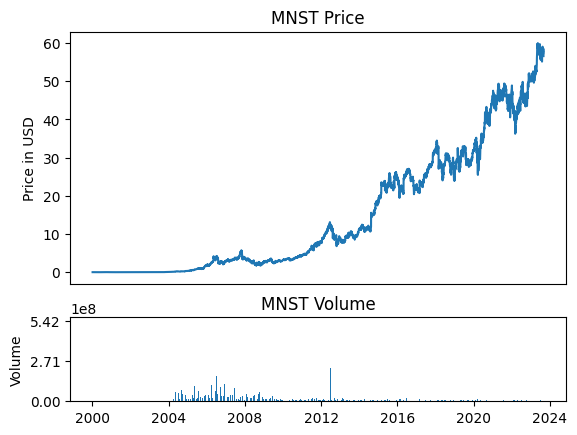

In [26]:
# Plot MNST's data and try to understand it better what is going on with the Adj Close price

plt.figure(figsize=(40, 10))
fig, axis = plt.subplots(2, 1, gridspec_kw={"height_ratios": [3, 1]})

axis[0].set_title("MNST Price")
axis[0].plot(MNST.index, MNST["Adj Close"])
axis[0].set_ylabel("Price in USD")
axis[0].xaxis.set_visible(False)

axis[1].set_title("MNST Volume")
axis[1].bar(MNST.index, MNST["Volume"])
axis[1].set_ylabel("Volume")
axis[1].set_yticks([MNST["Volume"].min(), (MNST["Volume"].min() + MNST["Volume"].max()) / 2, MNST["Volume"].max()])
axis[1].xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y"))
plt.show()

In [27]:
MNST_prices_daily_change = MNST["Adj Close"].pct_change(1)

In [28]:
# Calculate volatilitiy

volatility = (MNST_prices_daily_change.std() * 100)

# Calculate avarage daily returns %
daily_return = (MNST_prices_daily_change.mean() * 100)

# Calculate avarage yearly returns % (approx to 252 avarage trading days / year)
yearly_return = (MNST_prices_daily_change.mean() * 100 * 252)

print("MNST had a yearly performance of {}%, a daily performance of {}% with a {} volatility.".format(yearly_return, daily_return, volatility))

MNST had a yearly performance of 40.24557952620999%, a daily performance of 0.15970468065956345% with a 2.8347847528033343 volatility.


### Get a few best, worst amd avarage ETFs and Stocks
the assumtion is that the assest are still held today, therefore only current price based changes are used

The avarage ones will be used mainly for the baseline

The best and worst is only for entertainment

In [29]:
# Avarage ETFs the baselines will be picked from them
ETFs_mean_return = baseline_performance[baseline_performance["ETF"] == True]["Current pct_change"].mean()
print("The avarage performance of the ETFs {} % total".format(ETFs_mean_return * 100))

The avarage performance of the ETFs 305.9567619747139 % total


In [30]:
avg_ETFs = baseline_performance.iloc[(baseline_performance[baseline_performance["ETF"] == True]["Current pct_change"] - ETFs_mean_return).abs().argsort()[0:7],:]
avg_ETFs

,Symbol,First Date,First Adj Close,Highest Adj Close Date,Highest Adj Close,Lowest Adj Close Date,Lowest Adj Close,Current Adj Close Date,Current Adj Close,ETF,Highest pct_change,Lowest pct_change,Current pct_change
14,EWL,2000-01-03,11.442809,2021-12-29,53.020000,2003-03-12,6.658945,2023-09-01,45.930000,True,3.633478,-0.418067,3.013875
7,XLK,2000-01-03,42.751957,2023-07-18,180.259995,2002-10-09,8.930201,2023-09-01,176.199997,True,3.216415,-0.791116,3.121449
2,EWC,2000-01-03,8.789878,2022-03-30,40.660000,2002-10-09,5.766855,2023-09-01,34.930000,True,3.625775,-0.343921,2.973889
26,XLF,2000-01-03,9.248327,2022-01-12,41.419998,2009-03-06,3.068984,2023-09-01,34.689999,True,3.478648,-0.668158,2.750948
24,EWO,2000-01-03,5.655271,2007-06-04,28.348576,2000-10-18,4.365574,2023-09-01,20.270000,True,4.012771,-0.228052,2.584267
25,QQQ,2000-01-03,82.267441,2021-11-19,403.989990,2002-10-09,17.417257,2023-09-01,377.589996,True,3.910691,-0.788285,3.589787
21,SPY,2000-01-03,97.506668,2022-01-03,477.709991,2009-03-09,53.155308,2023-09-01,451.190002,True,3.899255,-0.454855,3.627273


In [31]:
# Best ETFs only for fun
best_ETFs = baseline_performance[baseline_performance["ETF"] == True].nlargest(5, "Current pct_change")
best_ETFs

,Symbol,First Date,First Adj Close,Highest Adj Close Date,Highest Adj Close,Lowest Adj Close Date,Lowest Adj Close,Current Adj Close Date,Current Adj Close,ETF,Highest pct_change,Lowest pct_change,Current pct_change
16,BBH,2000-01-03,18.336540,2021-08-09,220.750000,2002-07-10,8.318973,2023-09-01,164.910004,True,11.038803,-0.546317,7.993518
11,MDY,2000-01-03,62.596531,2021-11-16,531.030029,2002-10-09,54.648174,2023-09-01,488.420013,True,7.483378,-0.126978,6.802669
5,XLY,2000-01-03,23.193295,2021-11-19,211.419998,2009-03-09,13.498015,2023-09-01,169.669998,True,8.115566,-0.418021,6.315476
17,XLV,2000-01-03,22.068640,2022-04-08,142.830002,2001-09-20,15.964645,2023-09-01,133.570007,True,5.472080,-0.276591,5.052480
10,XLE,2000-01-03,15.853834,2022-11-15,94.080002,2002-07-23,12.327965,2023-09-01,90.739998,True,4.934211,-0.222399,4.723536


In [32]:
# Worst ETFs only for fun
worst_ETFs = baseline_performance[baseline_performance["ETF"] == True].nsmallest(5, "Current pct_change")
worst_ETFs

,Symbol,First Date,First Adj Close,Highest Adj Close Date,Highest Adj Close,Lowest Adj Close Date,Lowest Adj Close,Current Adj Close Date,Current Adj Close,ETF,Highest pct_change,Lowest pct_change,Current pct_change
0,EWJ,2000-01-03,47.173790,2021-09-15,74.120003,2003-04-25,19.765661,2023-09-01,62.040001,True,0.571212,-0.581003,0.315137
28,EWI,2000-01-03,21.784430,2007-05-07,45.699600,2009-03-09,13.534723,2023-09-01,31.840000,True,1.097810,-0.378697,0.461594
31,EWU,2000-01-03,19.796043,2022-02-09,34.759998,2003-03-12,10.534579,2023-09-01,32.060001,True,0.755906,-0.467844,0.619516
30,EWG,2000-01-03,15.368237,2021-06-07,35.870651,2003-03-12,5.553696,2023-09-01,27.610001,True,1.334077,-0.638625,0.796563
1,EWM,2000-01-03,11.309934,2014-08-27,36.642010,2001-04-09,5.949835,2023-09-01,21.230000,True,2.239808,-0.473928,0.877111


In [33]:
# Avarage Stcoks the baselines will be picked from them plus a few handpicked as well
Stock_mean_return = baseline_performance[baseline_performance["ETF"] == False]["Current pct_change"].mean()
print("The avarage performance of the ETFs {} % total".format(Stock_mean_return * 100))

The avarage performance of the ETFs 1169.3448537234528 % total


In [34]:
# This somehow let an ETF == True through???
#avg_Stocks = baseline_performance.iloc[(baseline_performance[baseline_performance["ETF"] == False]["Current pct_change"] - Stock_mean_return).abs().argsort()[0:15],:]

baseline_perf_stocks = baseline_performance[baseline_performance["ETF"] == False]
avg_Stocks = baseline_performance.iloc[(baseline_performance["Current pct_change"] - Stock_mean_return).abs().argsort()[0:7],:]
avg_Stocks

,Symbol,First Date,First Adj Close,Highest Adj Close Date,Highest Adj Close,Lowest Adj Close Date,Lowest Adj Close,Current Adj Close Date,Current Adj Close,ETF,Highest pct_change,Lowest pct_change,Current pct_change
1460,ZEUS,2000-01-03,4.378227,2008-06-30,69.836151,2000-10-25,1.705803,2023-09-01,55.580002,False,14.950784,-0.610390,11.694638
276,RGR,2000-01-03,4.076435,2021-06-30,87.934952,2008-11-20,3.048036,2023-09-01,51.779999,False,20.571535,-0.252279,11.702276
1248,BWA,2000-01-03,3.249329,2014-07-09,51.952221,2000-02-24,2.537365,2023-09-01,41.290001,False,14.988602,-0.219111,11.707241
1688,ECL,2000-01-03,14.446023,2021-12-29,235.639999,2000-02-29,10.828531,2023-09-01,182.699997,False,15.311756,-0.250414,11.647079
985,SHYF,2000-01-03,1.290543,2021-11-17,54.250000,2000-12-28,0.418953,2023-09-01,16.320000,False,41.036567,-0.675367,11.645839
43,PZZA,2000-01-03,6.033363,2021-11-04,140.009995,2000-12-19,4.426346,2023-09-01,77.150002,False,22.205963,-0.266355,11.787230
872,CASS,2000-01-03,3.042775,2018-06-22,57.866196,2000-10-25,2.700127,2023-09-01,38.290001,False,18.017575,-0.112610,11.583909


In [35]:
# Best Stocks only for fun
best_Stocks = baseline_performance[baseline_performance["ETF"] == False].nlargest(5, "Current pct_change")
best_Stocks

,Symbol,First Date,First Adj Close,Highest Adj Close Date,Highest Adj Close,Lowest Adj Close Date,Lowest Adj Close,Current Adj Close Date,Current Adj Close,ETF,Highest pct_change,Lowest pct_change,Current pct_change
1740,MNST,2000-01-03,0.044922,2023-05-16,59.939999,2001-05-08,0.030521,2023-09-01,56.549999,False,1333.312729,-0.320578,1257.848608
1682,DECK,2000-01-03,0.875000,2023-08-07,565.549988,2000-01-10,0.833333,2023-09-01,532.750000,False,645.342843,-0.047619,607.857143
1854,NVDA,2000-01-03,0.896152,2023-08-31,493.549988,2002-10-09,0.564349,2023-09-01,485.089996,False,549.743781,-0.370253,540.303425
1597,ODFL,2000-01-03,0.969398,2023-09-01,435.869995,2000-10-12,0.732434,2023-09-01,435.869995,False,448.629742,-0.244444,448.629742
1313,TPL,2000-01-03,5.617586,2022-11-07,2715.060059,2000-11-13,5.037743,2023-09-01,1908.329956,False,482.314403,-0.103219,338.706428


In [36]:
# Worst Stocks only for fun
worst_Stocks = baseline_performance[baseline_performance["ETF"] == False].nsmallest(5, "Current pct_change")
worst_Stocks

,Symbol,First Date,First Adj Close,Highest Adj Close Date,Highest Adj Close,Lowest Adj Close Date,Lowest Adj Close,Current Adj Close Date,Current Adj Close,ETF,Highest pct_change,Lowest pct_change,Current pct_change
241,NXPL,2000-01-03,3.796875e+10,2000-02-28,7.846875e+10,2019-08-26,0.23,2023-09-01,2.18,False,1.066667,-1.000000,-1.000000
200,WINT,2000-01-03,1.535625e+06,2004-03-08,8.290800e+06,2023-08-25,1.06,2023-09-01,1.18,False,4.398974,-0.999999,-0.999999
476,DOMH,2000-01-03,1.373851e+06,2000-02-07,3.612146e+06,2023-05-22,2.33,2023-09-01,2.73,False,1.629213,-0.999998,-0.999998
1051,AULT,2000-01-03,3.750000e+05,2000-09-11,3.225000e+06,2023-08-31,1.01,2023-09-01,1.05,False,7.600000,-0.999997,-0.999997
1122,ABIO,2000-01-03,7.087500e+05,2000-02-18,5.726700e+06,2022-01-28,1.77,2023-09-01,2.06,False,7.080000,-0.999998,-0.999997


### Save the temporary generated data objects for later use

In [37]:
# import libraries
import pickle

In [38]:
# dump objects
with open("3_1_baseline_performance.pckl", "wb") as f:
    %time pickle.dump(baseline_performance, f)

CPU times: user 1.27 ms, sys: 383 µs, total: 1.65 ms
Wall time: 1.62 ms


In [39]:
with open("3_1_avg_stocks.pckl", "wb") as f:
    %time pickle.dump(avg_Stocks, f)

CPU times: user 122 µs, sys: 0 ns, total: 122 µs
Wall time: 124 µs


In [40]:
with open("3_1_avg_etfs.pckl", "wb") as f:
    %time pickle.dump(avg_ETFs, f)

CPU times: user 94 µs, sys: 28 µs, total: 122 µs
Wall time: 125 µs


In [41]:
with open("3_1_stock.pckl", "wb") as f:
    %time pickle.dump(Stocks, f)

CPU times: user 2.32 s, sys: 250 ms, total: 2.57 s
Wall time: 2.6 s


In [42]:
with open("3_1_etfs.pckl", "wb") as f:
    %time pickle.dump(ETFs, f)

CPU times: user 22.4 ms, sys: 3.57 ms, total: 25.9 ms
Wall time: 26.6 ms
